In [1]:
from utils import create_directory

analysis_path = "results/analysis"
create_directory(analysis_path)

Directory 'results/analysis' already exists.


In [2]:
import os
import json
import pandas as pd

def collect_results(base_path="results", embeddings_base="embeddings", include_components=False):
    rows = []

    # --- helpers ---
    def read_classification_report(path):
        if not os.path.exists(path):
            return None, None, None, None
        with open(path, "r") as f:
            report = json.load(f)
        acc = report.get("accuracy", 0.0)
        macro = report.get("macro avg", {}) or {}
        precision = macro.get("precision", 0.0)
        recall = macro.get("recall", 0.0)
        f1 = macro.get("f1-score", 0.0)
        return acc, precision, recall, f1

    def _sum_emissions_from_df(df):
        # aceita 'emissions' ou 'emission'
        em_col = "emissions" if "emissions" in df.columns else ("emission" if "emission" in df.columns else None)
        if em_col is None:
            return 0.0, 0.0
        # garante colunas esperadas
        if "project_name" not in df.columns:
            return 0.0, 0.0
        em_train = df.loc[df["project_name"] == "train_val", em_col].sum()
        em_test  = df.loc[df["project_name"] == "test", em_col].sum()
        return float(em_train or 0.0), float(em_test or 0.0)

    def read_emissions(path):
        if not os.path.exists(path):
            return 0.0, 0.0
        df = pd.read_csv(path)
        return _sum_emissions_from_df(df)

    def read_embedding_emissions(embedding_model):
        if not embedding_model:
            return 0.0, 0.0
        path = os.path.join(embeddings_base, embedding_model, "emissions.csv")
        return read_emissions(path)

    # --- 1) string_match e fuzzy_match ---
    for sub in ["string_match", "fuzzy_match"]:
        report_path = os.path.join(base_path, sub, "test_classification_report.json")
        emissions_path = os.path.join(base_path, sub, "emissions.csv")

        acc, prec, rec, f1 = read_classification_report(report_path)
        method_em_train, method_em_test = read_emissions(emissions_path)

        row = {
            "method": sub,
            "embedding_model": None,
            "pooling_method": None,
            "classifier_model": None,
            "accuracy": acc,
            "macro_precision": prec,
            "macro_recall": rec,
            "macro_f1": f1,
            "emissions_train_val": method_em_train,
            "emissions_test": method_em_test
        }
        if include_components:
            row.update({
                "emissions_method_train_val": method_em_train,
                "emissions_method_test": method_em_test,
                "emissions_embed_train_val": 0.0,
                "emissions_embed_test": 0.0,
            })
        rows.append(row)

    # --- 2) BERT_threshold ---
    bert_thresh_path = os.path.join(base_path, "BERT_threshold")
    if os.path.exists(bert_thresh_path):
        for embedding_model in os.listdir(bert_thresh_path):
            emb_path = os.path.join(bert_thresh_path, embedding_model)
            if not os.path.isdir(emb_path):
                continue

            report_path = os.path.join(emb_path, "test_classification_report.json")
            emissions_path = os.path.join(emb_path, "emissions.csv")

            acc, prec, rec, f1 = read_classification_report(report_path)
            method_em_train, method_em_test = read_emissions(emissions_path)

            # soma com as emissões da geração das embeddings
            embed_em_train, embed_em_test = read_embedding_emissions(embedding_model)

            row = {
                "method": "BERT_threshold",
                "embedding_model": embedding_model,
                "pooling_method": None,
                "classifier_model": None,
                "accuracy": acc,
                "macro_precision": prec,
                "macro_recall": rec,
                "macro_f1": f1,
                "emissions_train_val": method_em_train + embed_em_train,
                "emissions_test": method_em_test + embed_em_test
            }
            if include_components:
                row.update({
                    "emissions_method_train_val": method_em_train,
                    "emissions_method_test": method_em_test,
                    "emissions_embed_train_val": embed_em_train,
                    "emissions_embed_test": embed_em_test,
                })
            rows.append(row)

    # --- 3) BERT_classifiers ---
    bert_class_path = os.path.join(base_path, "BERT_classifiers")
    if os.path.exists(bert_class_path):
        for embedding_model in os.listdir(bert_class_path):
            emb_path = os.path.join(bert_class_path, embedding_model)
            if not os.path.isdir(emb_path):
                continue

            # emissões da geração das embeddings (uma vez por embedding_model)
            embed_em_train, embed_em_test = read_embedding_emissions(embedding_model)

            for pooling_method in os.listdir(emb_path):
                pool_path = os.path.join(emb_path, pooling_method)
                if not os.path.isdir(pool_path):
                    continue

                for classifier_model in os.listdir(pool_path):
                    clf_path = os.path.join(pool_path, classifier_model)
                    if not os.path.isdir(clf_path):
                        continue

                    report_path = os.path.join(clf_path, "test_classification_report.json")
                    emissions_path = os.path.join(clf_path, "emissions.csv")

                    acc, prec, rec, f1 = read_classification_report(report_path)
                    method_em_train, method_em_test = read_emissions(emissions_path)

                    row = {
                        "method": "BERT_classifiers",
                        "embedding_model": embedding_model,
                        "pooling_method": pooling_method,
                        "classifier_model": classifier_model,
                        "accuracy": acc,
                        "macro_precision": prec,
                        "macro_recall": rec,
                        "macro_f1": f1,
                        "emissions_train_val": method_em_train + embed_em_train,
                        "emissions_test": method_em_test + embed_em_test
                    }
                    if include_components:
                        row.update({
                            "emissions_method_train_val": method_em_train,
                            "emissions_method_test": method_em_test,
                            "emissions_embed_train_val": embed_em_train,
                            "emissions_embed_test": embed_em_test,
                        })
                    rows.append(row)

    return pd.DataFrame(rows)

# ---- Uso ----
df = collect_results(base_path="results", embeddings_base="embeddings", include_components=False)
df


,method,embedding_model,pooling_method,classifier_model,accuracy,macro_precision,macro_recall,macro_f1,emissions_train_val,emissions_test
0,string_match,None,None,None,0.787158,0.618822,0.505621,0.456430,0.000000,0.000002
1,fuzzy_match,None,None,None,0.632342,0.561585,0.585922,0.554470,0.000044,0.000003
2,BERT_threshold,ibm-granite_granite-embedding-278m-multilingual,None,None,0.653032,0.593687,0.633281,0.587316,0.001769,0.000443
3,BERT_threshold,sentence-transformers_paraphrase-multilingual-...,None,None,0.708323,0.587651,0.599288,0.591677,0.000471,0.000122
4,BERT_threshold,sentence-transformers_paraphrase-multilingual-...,None,None,0.738050,0.563214,0.545383,0.547797,0.000157,0.000002
...,...,...,...,...,...,...,...,...,...,...
60,BERT_classifiers,sentence-transformers_paraphrase-multilingual-...,mean,RandomForest,0.835077,0.798614,0.650404,0.680776,0.001272,0.000002
61,BERT_classifiers,sentence-transformers_paraphrase-multilingual-...,mean,KNN,0.852556,0.786161,0.747996,0.764093,0.000189,0.000005
62,BERT_classifiers,sentence-transformers_paraphrase-multilingual-...,mean,SVM,0.799049,0.719733,0.552317,0.546129,0.000321,0.000002
63,BERT_classifiers,sentence-transformers_paraphrase-multilingual-...,mean,LogReg,0.797860,0.708890,0.552997,0.547786,0.000211,0.000003


In [3]:
import pandas as pd

# supondo que seu df já exista
resultados = []

# 1. Pegar todos os string_match e fuzzy_match
filtros = df[df["method"].isin(["string_match", "fuzzy_match"])]
resultados.append(filtros)

# 2. Pegar o melhor BERT_threshold
bert_threshold = df[df["method"] == "BERT_threshold"].sort_values("macro_f1", ascending=False).head(1)
resultados.append(bert_threshold)

# 3. Pegar o melhor BERT_classifiers por classifier_model
bert_classifiers = (
    df[df["method"] == "BERT_classifiers"]
    .sort_values("macro_f1", ascending=False)
    .groupby("classifier_model")
    .head(1)
)
resultados.append(bert_classifiers)

# Concatenar tudo em um único DataFrame
final = pd.concat(resultados).reset_index(drop=True)
final.to_csv(f"{analysis_path}/best_results.csv", index=False)
final

,method,embedding_model,pooling_method,classifier_model,accuracy,macro_precision,macro_recall,macro_f1,emissions_train_val,emissions_test
0,string_match,None,None,None,0.787158,0.618822,0.505621,0.456430,0.000000,0.000002
1,fuzzy_match,None,None,None,0.632342,0.561585,0.585922,0.554470,0.000044,0.000003
2,BERT_threshold,sentence-transformers_paraphrase-multilingual-...,None,None,0.708323,0.587651,0.599288,0.591677,0.000471,0.000122
3,BERT_classifiers,ibm-granite_granite-embedding-278m-multilingual,max,KNN,0.859096,0.794063,0.767519,0.779395,0.001821,0.000445
4,BERT_classifiers,sentence-transformers_paraphrase-multilingual-...,concatenate,DecisionTree,0.828894,0.743972,0.744870,0.744419,0.001044,0.000122
5,BERT_classifiers,ibm-granite_granite-embedding-278m-multilingual,max,RandomForest,0.853389,0.817930,0.701789,0.735622,0.002928,0.000442
6,BERT_classifiers,ibm-granite_granite-embedding-278m-multilingual,min,LogReg,0.823187,0.749797,0.650649,0.675749,0.001769,0.000443
7,BERT_classifiers,ibm-granite_granite-embedding-278m-multilingual,max,SVM,0.823900,0.757872,0.642287,0.668002,0.001779,0.000443


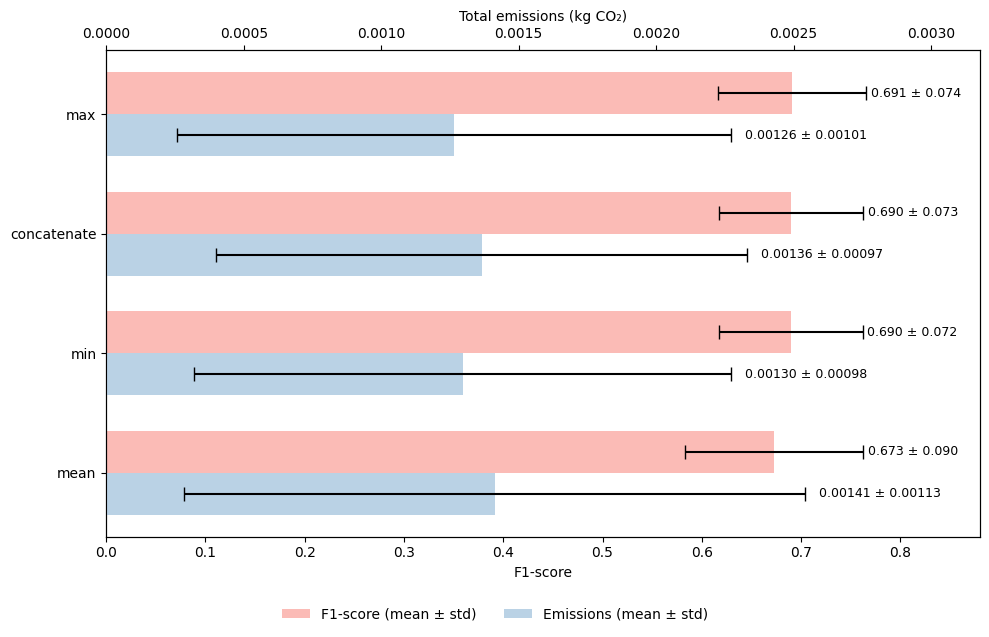

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare data
df_classifiers = df[df["method"] == "BERT_classifiers"].copy()
df_classifiers["emissions_total"] = (
    df_classifiers["emissions_train_val"].fillna(0) + df_classifiers["emissions_test"].fillna(0)
)

agg = df_classifiers.groupby("pooling_method").agg(
    mean_f1=("macro_f1", "mean"),
    std_f1=("macro_f1", "std"),
    mean_em=("emissions_total", "mean"),
    std_em=("emissions_total", "std"),
).reset_index()

# Sort by F1
agg = agg.sort_values("mean_f1", ascending=False).reset_index(drop=True)

y = np.arange(len(agg))
height = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))

# Pastel1 palette
colors = plt.cm.Pastel1.colors
color_f1 = colors[0]
color_em = colors[1]

# F1 bars (blue pastel)
bars1 = ax1.barh(y - height/2, agg["mean_f1"], height,
                 xerr=agg["std_f1"], capsize=5,
                 color=color_f1, alpha=0.9, label="F1-score (mean ± std)")
ax1.set_xlabel("F1-score")
ax1.set_yticks(y)
ax1.set_yticklabels(agg["pooling_method"])
ax1.invert_yaxis()

# F1 labels
max_f1 = (agg["mean_f1"] + agg["std_f1"]).max()
for i, (m, s) in enumerate(zip(agg["mean_f1"], agg["std_f1"])):
    s_val = 0 if np.isnan(s) else s
    ax1.text(m + s_val + 0.005, i - height/2,
             f"{m:.3f} ± {s_val:.3f}",
             va="center", fontsize=9, color="black")

# Adjust x-axis limit for F1
ax1.set_xlim(0, max_f1 * 1.15)

# Emission bars (purple pastel)
ax2 = ax1.twiny()
bars2 = ax2.barh(y + height/2, agg["mean_em"], height,
                 xerr=agg["std_em"], capsize=5,
                 color=color_em, alpha=0.9, label="Emissions (mean ± std)")
ax2.set_xlabel("Total emissions (kg CO₂)")

# Emission labels
max_em = (agg["mean_em"] + agg["std_em"]).max()
for i, (m, s) in enumerate(zip(agg["mean_em"], agg["std_em"])):
    s_val = 0 if np.isnan(s) else s
    ax2.text(m + s_val + max_em * 0.02, i + height/2,
             f"{m:,.5f} ± {s_val:,.5f}",
             va="center", fontsize=9, color="black")

# Adjust x-axis limit for emissions
ax2.set_xlim(0, max_em * 1.25)

# Legend below
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 0.0),
           ncol=2, frameon=False, fontsize=10)

plt.tight_layout()
plt.savefig(f"{analysis_path}/pooling.pdf", bbox_inches="tight")
plt.show()


In [5]:
from scipy.stats import kruskal

# Collect F1-score values for each pooling method
grouped_data = [
    group["macro_f1"].values
    for _, group in df_classifiers.groupby("pooling_method")
]

# Kruskal-Wallis test
stat, p_value = kruskal(*grouped_data)

print(f"Kruskal-Wallis statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Statistically significant difference found between at least two pooling methods.")
else:
    print("No statistically significant difference detected.")


Kruskal-Wallis statistic: 0.2403
P-value: 0.9708
No statistically significant difference detected.


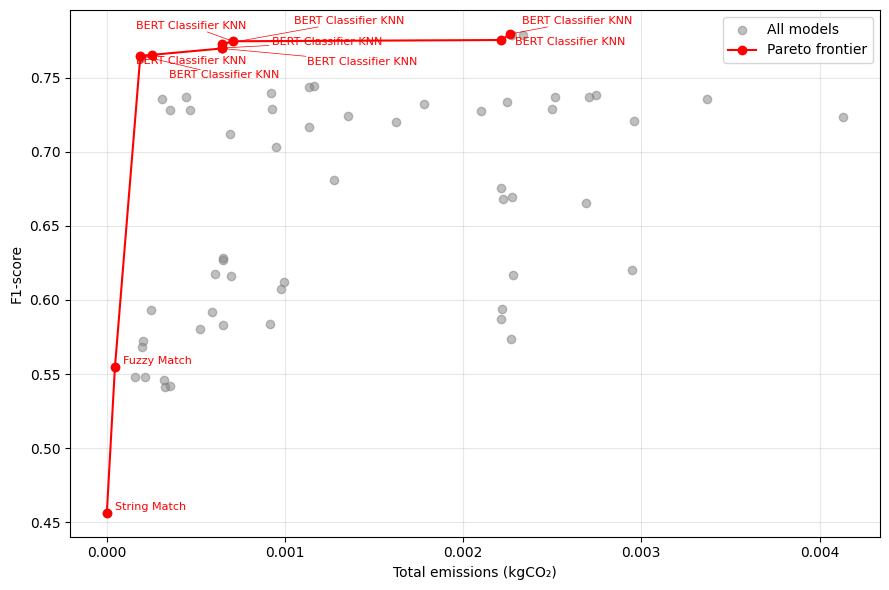

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from adjustText import adjust_text

# --- compute total emissions (kg CO₂) ---
df["emissions_total"] = df["emissions_train_val"].fillna(0) + df["emissions_test"].fillna(0)

# --- sort by emissions ---
points = df.sort_values("emissions_total")[["emissions_total","macro_f1","method","classifier_model"]].reset_index(drop=True)

# --- find Pareto frontier ---
pareto = []
max_f1 = -1
for i,row in points.iterrows():
    if row["macro_f1"] > max_f1:  # only keep non-dominated
        pareto.append(row)
        max_f1 = row["macro_f1"]
pareto_df = pd.DataFrame(pareto)

# --- mapping for nicer labels ---
method_map = {
    "string_match": "String Match",
    "fuzzy_match": "Fuzzy Match",
    "BERT_threshold": "BERT Threshold",
    "BERT_classifiers": "BERT Classifier"
}

def make_label(row):
    base = method_map.get(row["method"], row["method"])
    if row["method"] == "BERT_classifiers" and row["classifier_model"] == "KNN":
        return "BERT Classifier KNN"
    return base

# --- plot ---
plt.figure(figsize=(9,6))

# all points in gray
plt.scatter(points["emissions_total"], points["macro_f1"], c="gray", alpha=0.5, label="All models")

# Pareto frontier in red
plt.plot(pareto_df["emissions_total"], pareto_df["macro_f1"], "r-o", label="Pareto frontier")

# labels only for frontier points
texts = []
for _,row in pareto_df.iterrows():
    label = make_label(row)
    texts.append(plt.text(row["emissions_total"], row["macro_f1"], label, fontsize=8, color="red"))

adjust_text(texts, arrowprops=dict(arrowstyle="->", color="red", lw=0.5))

plt.xlabel("Total emissions (kgCO₂)")
plt.ylabel("F1-score")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f"{analysis_path}/pareto.pdf", bbox_inches="tight")
plt.show()
